In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
df_train=pd.read_csv('/Users/mayankkapadia/Desktop/SJSUMATERIAL/SEM2/ML/Project/Dataset/train_data.csv')
df_test=pd.read_csv('/Users/mayankkapadia/Desktop/SJSUMATERIAL/SEM2/ML/Project/Dataset/test_data.csv')

In [3]:
for col in df_train.columns:
  if df_train[col].isna().any():
    print(col)

In [4]:
for col in df_test.columns:
  if df_test[col].isna().sum()>0:
    print(col)

In [5]:
df_train['Label']

0            BENIGN
1          PortScan
2            BENIGN
3            BENIGN
4            BENIGN
             ...   
2558775      BENIGN
2558776      BENIGN
2558777      BENIGN
2558778    DoS Hulk
2558779      BENIGN
Name: Label, Length: 2558780, dtype: object

In [6]:
df_train.head(1)

,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,Timestamp,FlowDuration,TotalFwdPackets,TotalBackwardPackets,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,192.168.10.3-192.168.10.12-53-26526-17,192.168.10.12,26526,192.168.10.3,53,17,6/7/2017 3:12,31419,2,2,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [7]:
df_test.head(1)

,FlowID,SourceIP,SourcePort,DestinationIP,DestinationPort,Protocol,Timestamp,FlowDuration,TotalFwdPackets,TotalBackwardPackets,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,192.168.10.5-211.233.74.132-58565-80-6,192.168.10.5,58565,211.233.74.132,80,6,6/7/2017 4:55,5658973,3,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [8]:
df_train['label_encoded']=df_train['Label'].apply(lambda x: 1 if x=='BENIGN' else 0)
X_train=df_train.drop(['Label','label_encoded','FlowID','SourceIP','DestinationIP','Timestamp'],axis=1)
y_train=df_train['label_encoded']

In [9]:
df_test['label_encoded']=df_test['Label'].apply(lambda x: 1 if x=='BENIGN' else 0)
X_test=df_test.drop(['Label','label_encoded','FlowID','SourceIP','DestinationIP','Timestamp'],axis=1)
y_test=df_test['label_encoded']

In [10]:
y_train.unique()

array([1, 0])

In [11]:
scaler=StandardScaler()
X_scaled_train=scaler.fit_transform(X_train)

In [12]:
X_scaled_test=scaler.transform(X_test)

In [13]:
X_scaled_train

array([[-0.68201212, -0.44825671,  1.39849855, ..., -0.10427153,
        -0.33890149, -0.32216095],
       [-0.19345685, -0.24700703, -0.71351109, ..., -0.10427153,
        -0.33890149, -0.32216095],
       [ 0.5454551 , -0.44678175, -0.71351109, ..., -0.10427153,
        -0.33890149, -0.32216095],
       ...,
       [ 0.75760711, -0.42695177, -0.71351109, ..., -0.10427153,
        -0.33890149, -0.32216095],
       [-0.35415324, -0.44678175, -0.71351109, ..., -0.10427153,
         3.90541   ,  4.10713564],
       [ 0.57182041, -0.44825671,  1.39849855, ..., -0.10427153,
        -0.33890149, -0.32216095]])

In [14]:
!pip install gym

In [15]:
#Creating Custom Gym Enviornment

import gym
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete
import numpy as np

In [16]:
class CICIDS2017_env(Env):
    def __init__(self, X, y):
        self.index = 0
        self.X = np.array(X)
        self.y = np.array(y)
        self.action_space = Discrete(2)
        self.observation_space = Box(low=-1, high=1, shape=(X.shape[1],), dtype=float)

    def step(self, action):
        true_label = self.y[self.index]
        if action == true_label:
            reward = 1
        elif action == 1 and true_label == 0:
            reward = -0.2  # False positive
        else:
            reward = -1    # False negative (missed attack)

        self.index += 1
        done = self.index >= len(self.X)
        obs = self.X[self.index] if not done else np.zeros_like(self.X[0])
        info = {}
        return obs, reward, done, info

    def reset(self):
        self.index = 0
        return self.X[self.index]

In [17]:
!pip install --upgrade stable-baselines3

In [18]:
pip install "shimmy>=2.0"

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Dummy warm-up run (discard result)
from stable_baselines3 import PPO
import gc
env_warmup = CICIDS2017_env(X_scaled_train, y_train)
model_warmup = PPO('MlpPolicy', env_warmup, verbose=0)
model_warmup.learn(total_timesteps=100)
del model_warmup, env_warmup
gc.collect()

/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


7

In [20]:
!pip install psutil


Training for 1000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 1000 | Accuracy: 0.5764 | Precision: 0.8069 | Recall: 0.5939 | F1: 0.6842 | Time: 2.08s | Memory: 121.30 MB

Training for 5000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 5000 | Accuracy: 0.7309 | Precision: 0.8627 | Recall: 0.7751 | F1: 0.8166 | Time: 4.39s | Memory: 197.31 MB

Training for 10000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 10000 | Accuracy: 0.8449 | Precision: 0.9001 | Recall: 0.8990 | F1: 0.8996 | Time: 6.31s | Memory: 582.95 MB

Training for 15000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 15000 | Accuracy: 0.8934 | Precision: 0.9069 | Recall: 0.9607 | F1: 0.9330 | Time: 9.49s | Memory: 393.84 MB

Training for 50000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 50000 | Accuracy: 0.9536 | Precision: 0.9683 | Recall: 0.9718 | F1: 0.9700 | Time: 27.64s | Memory: -377.81 MB

Training for 100000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 100000 | Accuracy: 0.9576 | Precision: 0.9653 | Recall: 0.9804 | F1: 0.9728 | Time: 52.60s | Memory: -351.23 MB

Training for 200000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 200000 | Accuracy: 0.9624 | Precision: 0.9728 | Recall: 0.9786 | F1: 0.9757 | Time: 104.10s | Memory: -85.58 MB

Training for 500000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 500000 | Accuracy: 0.9666 | Precision: 0.9735 | Recall: 0.9835 | F1: 0.9785 | Time: 254.74s | Memory: -524.06 MB


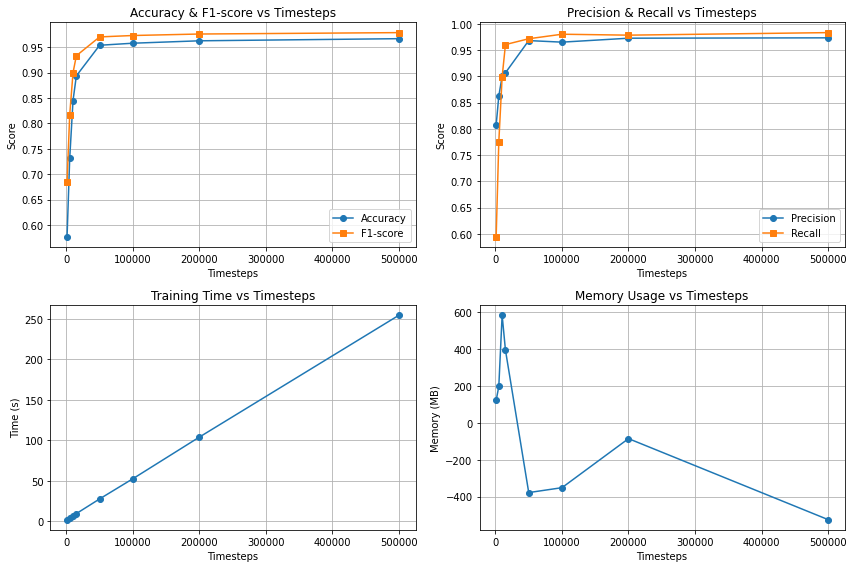

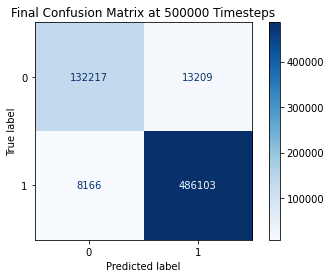

In [21]:
import time
import psutil
import matplotlib.pyplot as plt
import gc
import os
from stable_baselines3 import PPO
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Ensure output directory exists
os.makedirs("saved_models", exist_ok=True)
os.makedirs("confusion_matrices", exist_ok=True)

timesteps_list = [1000, 5000, 10000, 15000, 50000, 100000,200000,500000]
accuracies = []
precisions = []
recalls = []
f1_scores = []
train_times = []
memory_usages = []

final_conf_matrix = None  # Will store confusion matrix of last model

for t in timesteps_list:
    print(f"\nTraining for {t} timesteps...")

    gc.collect()

    start_time = time.time()
    process = psutil.Process()
    mem_before = process.memory_info().rss / (1024 ** 2)

    env_train = CICIDS2017_env(X_scaled_train, y_train)
    model = PPO('MlpPolicy', env_train, verbose=0)
    model.learn(total_timesteps=t)

    mem_after = process.memory_info().rss / (1024 ** 2)
    memory_used = mem_after - mem_before
    train_duration = time.time() - start_time

    # Save the model
    model_path = f"saved_models/ppo_cicids_{t}_timesteps.zip"
    model.save(model_path)

    # Evaluation
    env_test = CICIDS2017_env(X_scaled_test, y_test)
    obs = env_test.reset()
    true_labels, pred_labels = [], []

    for _ in range(len(X_scaled_test)):
        action, _ = model.predict(obs)
        true_labels.append(env_test.y[env_test.index])
        pred_labels.append(action)
        obs, reward, done, _ = env_test.step(action)
        if done:
            break

    # Metrics
    accuracy = sum([int(p == t) for p, t in zip(pred_labels, true_labels)]) / len(true_labels)
    precision = precision_score(true_labels, pred_labels, zero_division=0)
    recall = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    train_times.append(train_duration)
    memory_usages.append(memory_used)

    print(f"Timesteps: {t} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Time: {train_duration:.2f}s | Memory: {memory_used:.2f} MB")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix at {t} Timesteps")
    plt.grid(False)
    plt.savefig(f"confusion_matrices/conf_matrix_{t}_timesteps.png")
    plt.close()

    if t == timesteps_list[-1]:
        final_conf_matrix = cm

    del model, env_train, env_test
    gc.collect()

# Plotting results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(timesteps_list, accuracies, marker='o', label="Accuracy")
plt.plot(timesteps_list, f1_scores, marker='s', label="F1-score")
plt.xlabel("Timesteps")
plt.ylabel("Score")
plt.title("Accuracy & F1-score vs Timesteps")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(timesteps_list, precisions, marker='o', label="Precision")
plt.plot(timesteps_list, recalls, marker='s', label="Recall")
plt.xlabel("Timesteps")
plt.ylabel("Score")
plt.title("Precision & Recall vs Timesteps")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(timesteps_list, train_times, marker='o')
plt.xlabel("Timesteps")
plt.ylabel("Time (s)")
plt.title("Training Time vs Timesteps")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(timesteps_list, memory_usages, marker='o')
plt.xlabel("Timesteps")
plt.ylabel("Memory (MB)")
plt.title("Memory Usage vs Timesteps")
plt.grid(True)

plt.tight_layout()
plt.show()

# Show the last confusion matrix again
if final_conf_matrix is not None:
    disp = ConfusionMatrixDisplay(confusion_matrix=final_conf_matrix)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Final Confusion Matrix at {timesteps_list[-1]} Timesteps")
    plt.grid(False)
    plt.show()


#Now implementing for A2C Alogrithm


Training for 1000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 1000 | Accuracy: 0.7167 | Precision: 0.8162 | Recall: 0.8174 | F1: 0.8168 | Time: 1.82s | Memory: 226.38 MB

Training for 5000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 5000 | Accuracy: 0.7530 | Precision: 0.8203 | Recall: 0.8713 | F1: 0.8450 | Time: 4.14s | Memory: 121.28 MB

Training for 10000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 10000 | Accuracy: 0.8046 | Precision: 0.8298 | Recall: 0.9400 | F1: 0.8814 | Time: 6.68s | Memory: 883.00 MB

Training for 15000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 15000 | Accuracy: 0.8485 | Precision: 0.8450 | Recall: 0.9845 | F1: 0.9094 | Time: 9.52s | Memory: 402.39 MB

Training for 50000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 50000 | Accuracy: 0.8681 | Precision: 0.8573 | Recall: 0.9950 | F1: 0.9210 | Time: 29.77s | Memory: -600.25 MB

Training for 100000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 100000 | Accuracy: 0.8481 | Precision: 0.8365 | Recall: 0.9986 | F1: 0.9104 | Time: 58.09s | Memory: -402.02 MB


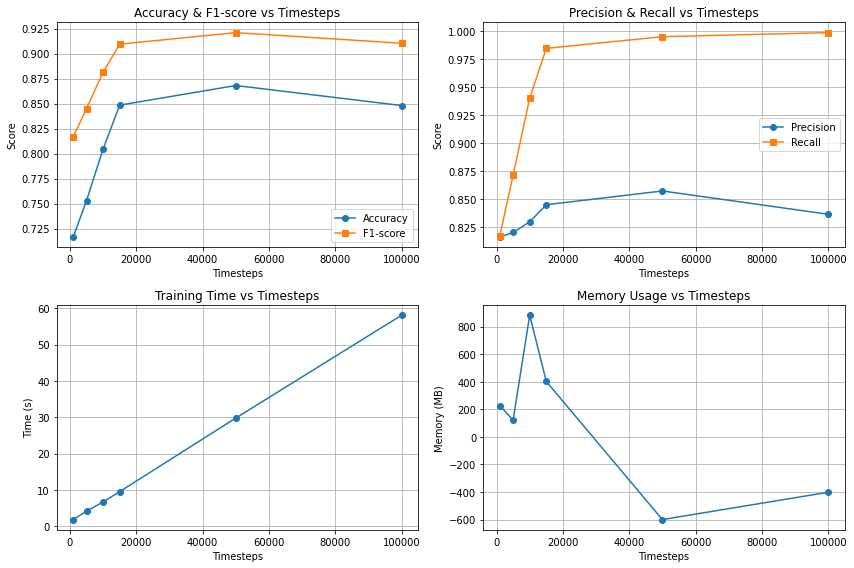

In [50]:
import time
import psutil
import matplotlib.pyplot as plt
import gc
from stable_baselines3 import A2C
from sklearn.metrics import precision_score, recall_score, f1_score

timesteps_list = [1000, 5000, 10000,15000,50000,100000]
accuracies = []
precisions = []
recalls = []
f1_scores = []
train_times = []
memory_usages = []

for t in timesteps_list:
    print(f"\nTraining for {t} timesteps...")

    gc.collect()

    start_time = time.time()
    process = psutil.Process()
    mem_before = process.memory_info().rss / (1024 ** 2)

    env_train = CICIDS2017_env(X_scaled_train, y_train)
    model = A2C('MlpPolicy', env_train, verbose=0)
    model.learn(total_timesteps=t)

    mem_after = process.memory_info().rss / (1024 ** 2)
    memory_used = mem_after - mem_before
    train_duration = time.time() - start_time

    # Evaluation
    env_test = CICIDS2017_env(X_scaled_test, y_test)
    obs = env_test.reset()
    true_labels, pred_labels = [], []

    for _ in range(len(X_scaled_test)):
        action, _ = model.predict(obs)
        true_labels.append(env_test.y[env_test.index])
        pred_labels.append(action)
        obs, reward, done, _ = env_test.step(action)
        if done:
            break

    accuracy = sum([int(p == t) for p, t in zip(pred_labels, true_labels)]) / len(true_labels)
    precision = precision_score(true_labels, pred_labels, zero_division=0)
    recall = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    train_times.append(train_duration)
    memory_usages.append(memory_used)

    print(f"Timesteps: {t} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Time: {train_duration:.2f}s | Memory: {memory_used:.2f} MB")

    del model, env_train, env_test
    gc.collect()

# Plotting results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(timesteps_list, accuracies, marker='o', label="Accuracy")
plt.plot(timesteps_list, f1_scores, marker='s', label="F1-score")
plt.xlabel("Timesteps")
plt.ylabel("Score")
plt.title("Accuracy & F1-score vs Timesteps")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(timesteps_list, precisions, marker='o', label="Precision")
plt.plot(timesteps_list, recalls, marker='s', label="Recall")
plt.xlabel("Timesteps")
plt.ylabel("Score")
plt.title("Precision & Recall vs Timesteps")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(timesteps_list, train_times, marker='o')
plt.xlabel("Timesteps")
plt.ylabel("Time (s)")
plt.title("Training Time vs Timesteps")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(timesteps_list, memory_usages, marker='o')
plt.xlabel("Timesteps")
plt.ylabel("Memory (MB)")
plt.title("Memory Usage vs Timesteps")
plt.grid(True)

plt.tight_layout()
plt.show()


#Now Implementing for DQN



Training for 1000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 1000 | Accuracy: 0.8256 | Precision: 0.8329 | Recall: 0.9686 | F1: 0.8956 | Time: 1.34s | Memory: 1124.95 MB

Training for 5000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 5000 | Accuracy: 0.8564 | Precision: 0.8614 | Recall: 0.9702 | F1: 0.9126 | Time: 2.82s | Memory: 1285.81 MB

Training for 10000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 10000 | Accuracy: 0.8861 | Precision: 0.8949 | Recall: 0.9661 | F1: 0.9291 | Time: 4.51s | Memory: 1095.83 MB

Training for 15000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 15000 | Accuracy: 0.9155 | Precision: 0.9347 | Recall: 0.9574 | F1: 0.9460 | Time: 6.42s | Memory: 1038.34 MB

Training for 50000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 50000 | Accuracy: 0.9391 | Precision: 0.9623 | Recall: 0.9588 | F1: 0.9605 | Time: 19.87s | Memory: 396.44 MB

Training for 100000 timesteps...


/Users/mayankkapadia/anaconda3/envs/testenv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Timesteps: 100000 | Accuracy: 0.9436 | Precision: 0.9668 | Recall: 0.9600 | F1: 0.9634 | Time: 38.97s | Memory: -532.86 MB


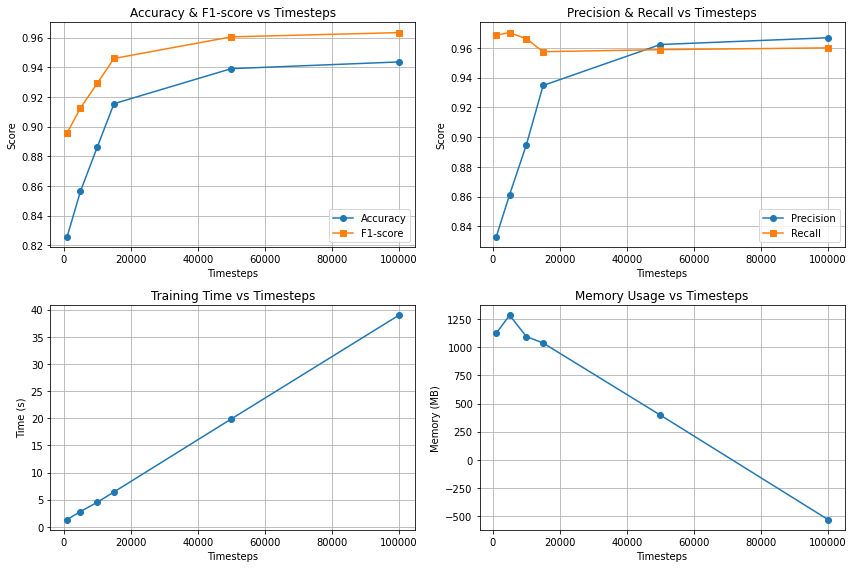

In [51]:
import time
import psutil
import matplotlib.pyplot as plt
import gc
from stable_baselines3 import DQN
from sklearn.metrics import precision_score, recall_score, f1_score

timesteps_list = [1000, 5000, 10000,15000,50000,100000]
accuracies = []
precisions = []
recalls = []
f1_scores = []
train_times = []
memory_usages = []

for t in timesteps_list:
    print(f"\nTraining for {t} timesteps...")

    gc.collect()

    start_time = time.time()
    process = psutil.Process()
    mem_before = process.memory_info().rss / (1024 ** 2)

    env_train = CICIDS2017_env(X_scaled_train, y_train)
    model = DQN('MlpPolicy', env_train, verbose=0)
    model.learn(total_timesteps=t)

    mem_after = process.memory_info().rss / (1024 ** 2)
    memory_used = mem_after - mem_before
    train_duration = time.time() - start_time

    # Evaluation
    env_test = CICIDS2017_env(X_scaled_test, y_test)
    obs = env_test.reset()
    true_labels, pred_labels = [], []

    for _ in range(len(X_scaled_test)):
        action, _ = model.predict(obs)
        true_labels.append(env_test.y[env_test.index])
        pred_labels.append(action)
        obs, reward, done, _ = env_test.step(action)
        if done:
            break

    accuracy = sum([int(p == t) for p, t in zip(pred_labels, true_labels)]) / len(true_labels)
    precision = precision_score(true_labels, pred_labels, zero_division=0)
    recall = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    train_times.append(train_duration)
    memory_usages.append(memory_used)

    print(f"Timesteps: {t} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Time: {train_duration:.2f}s | Memory: {memory_used:.2f} MB")

    del model, env_train, env_test
    gc.collect()

# Plotting results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(timesteps_list, accuracies, marker='o', label="Accuracy")
plt.plot(timesteps_list, f1_scores, marker='s', label="F1-score")
plt.xlabel("Timesteps")
plt.ylabel("Score")
plt.title("Accuracy & F1-score vs Timesteps")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(timesteps_list, precisions, marker='o', label="Precision")
plt.plot(timesteps_list, recalls, marker='s', label="Recall")
plt.xlabel("Timesteps")
plt.ylabel("Score")
plt.title("Precision & Recall vs Timesteps")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(timesteps_list, train_times, marker='o')
plt.xlabel("Timesteps")
plt.ylabel("Time (s)")
plt.title("Training Time vs Timesteps")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(timesteps_list, memory_usages, marker='o')
plt.xlabel("Timesteps")
plt.ylabel("Memory (MB)")
plt.title("Memory Usage vs Timesteps")
plt.grid(True)

plt.tight_layout()
plt.show()
